## Week 3 Seminar Questions

### 1.Data Retrieval and Analysis:
Retrieve the historical data for the S&P 500 and VIX indices (from October 1, 2022, to October 1, 2023) using yfinance.

Produce two visualizations: one showcasing each index separately and another featuring both on a single plot, utilizing subplots for visualization.

Compute the log returns of both and determine their correlation coefficient.

Generate visuals containing histograms and scatter plots of both using the scatter_matrix from pandas.

Employ numpy’s polyfit to linearly fit the two.

Bonus: Compute the correlation over a fixed window of 20 trading days.

### 2.Option Pricing Comparison:
Assume a risk-free rate of 4.5%.

Utilize the closing price of the S&P 500 on October 2, 2023, as the underlying asset price.

Calculate the price of a call option with a strike price of $4300, expiring in one month (November 1, 2023), using the annualized volatility derived from log returns between October 1, 2022, and October 1, 2023.

Retrieve and compare the actual market price of the option using yfinance.

Discuss potential reasons for the pricing discrepancy.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import scipy.stats as si


In [154]:
sp500 = yf.download('^SPX', start='2022-10-01', end='2023-10-02')
vix = yf.download('^VIX', start='2022-10-01', end='2023-10-02')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [155]:
print(sp500.columns)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


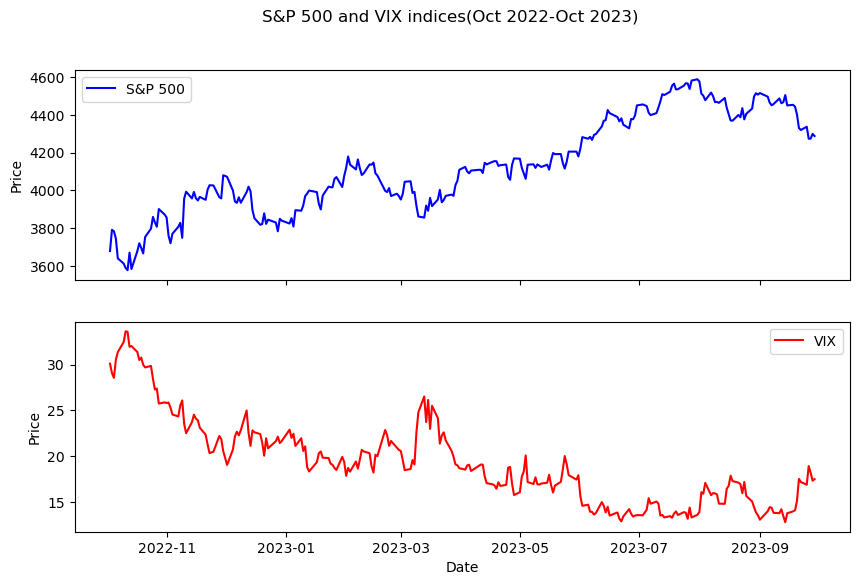

In [156]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,6))
fig.suptitle('S&P 500 and VIX indices(Oct 2022-Oct 2023)')
axs[0].plot(sp500['Adj Close'], label='S&P 500', color='b')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(vix['Adj Close'], label='VIX', color='r')
axs[1].set_ylabel('Price')
axs[1].set_xlabel('Date')
axs[1].legend()

plt.show()

Text(0.5, 1.0, 'S&P 500 and VIX indices (from Oct-2022 to Oct-2023')

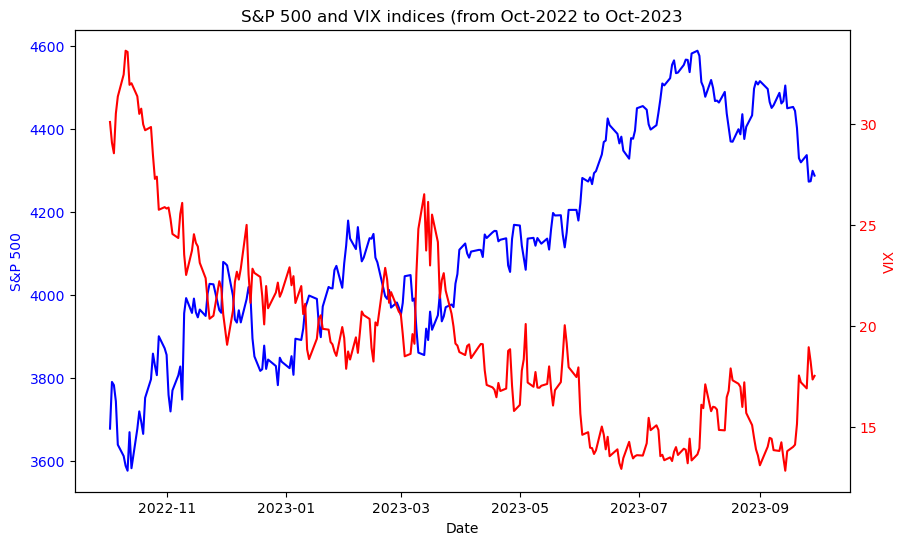

In [157]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_ylabel('S&P 500', color='b')
ax1.set_xlabel('Date')
ax1.plot(sp500['Adj Close'],color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.set_ylabel('VIX',color='r')
ax2.plot(vix['Adj Close'],color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('S&P 500 and VIX indices (from Oct-2022 to Oct-2023')

In [158]:
sp500['log return'] = np.log(sp500['Adj Close']/sp500['Adj Close'].shift(1))
vix['log return'] = np.log(vix['Adj Close']/vix['Adj Close'].shift(1))


In [159]:
correlation = sp500['log return'].corr(vix['log return'])

In [160]:
print("{:.4f}".format(correlation))

-0.6364


In [161]:
print(f"the correlation between the log returns of sp500 and vix from Oct 2022-Oct 2023 is {correlation:.4f}")

the correlation between the log returns of sp500 and vix from Oct 2022-Oct 2023 is -0.6364


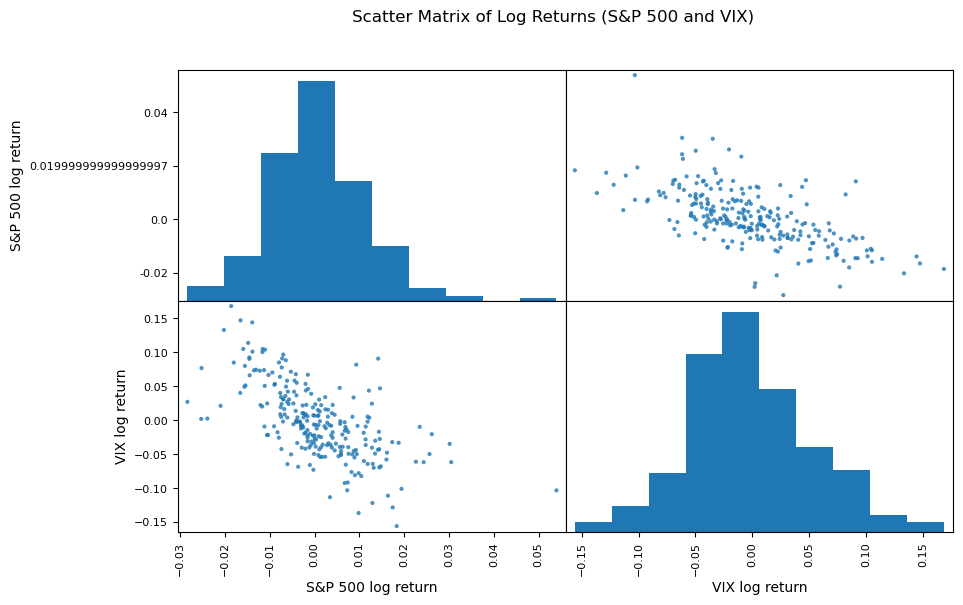

In [162]:
# Creating a DataFrame with log returns
data = pd.DataFrame({'S&P 500 log return': sp500['log return'], 'VIX log return': vix['log return']}).dropna()

# Scatter matrix
pd.plotting.scatter_matrix(data, alpha=0.8, figsize=(10, 6), diagonal='hist')
plt.suptitle('Scatter Matrix of Log Returns (S&P 500 and VIX)')
plt.show()

In [163]:
fit = np.polyfit(data['S&P 500 log return'],data['VIX log return'],1)

In [164]:
slope, intercept = fit
print(f"the linear regression model is Y = {slope:.4f}X + {intercept:.4f}")

the linear regression model is Y = -3.2097X + -0.0002


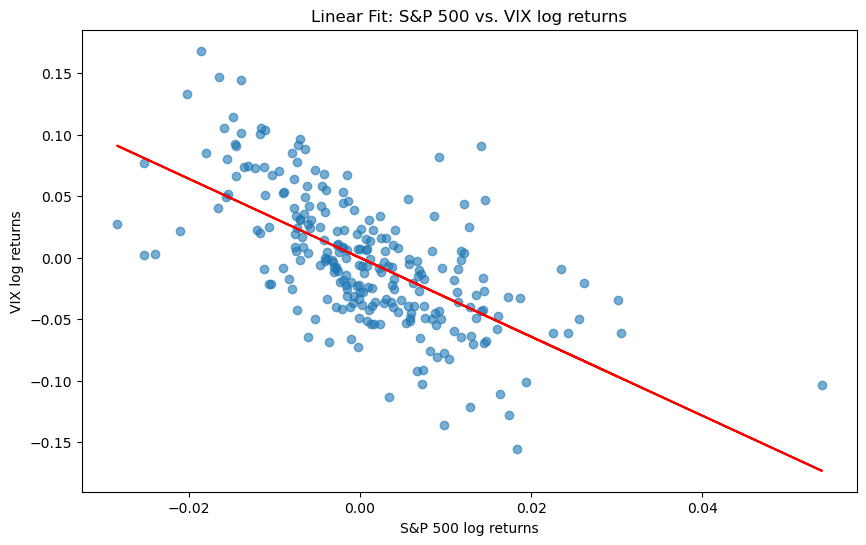

In [165]:
plt.figure(figsize=(10,6))
plt.scatter(data['S&P 500 log return'],data['VIX log return'], alpha=0.6)
plt.plot(data['S&P 500 log return'], np.polyval(fit, data['S&P 500 log return']), color = 'red')
plt.title('Linear Fit: S&P 500 vs. VIX log returns')
plt.ylabel('VIX log returns')
plt.xlabel('S&P 500 log returns')
plt.show()

In [166]:
# Compute the rolling correlation over a fixed window of 20 trading days.

rolling_corr = data['S&P 500 log return'].rolling(window=20).corr(data['VIX log return'])

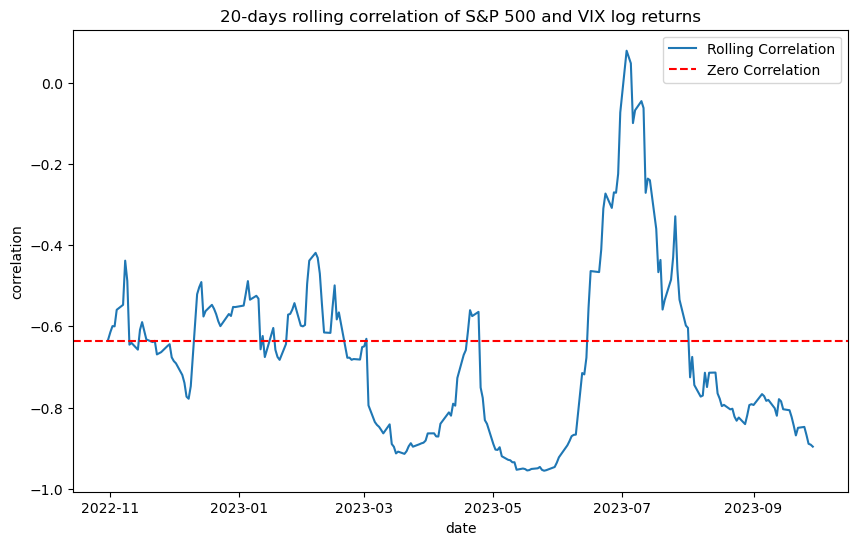

In [167]:
plt.figure(figsize=(10,6))
plt.plot(rolling_corr, label='Rolling Correlation')
plt.axhline(correlation, color='red', linestyle='--',label='Zero Correlation')
plt.title('20-days rolling correlation of S&P 500 and VIX log returns')
plt.xlabel('date')
plt.ylabel('correlation')
plt.legend()
plt.show()

In [168]:
## Q2: Option Pricing Comparison

def black_scholes_call(S,K,T,r,sigma):
    """
    
    S: Current price of the underlying asset
    K: Option strike price
    T: TIme to expiration
    r: Risk-free rate
    sigma: Volatility
    """
    
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call_price

In [169]:
S = yf.download('^SPX', start = '2023-10-02', end = '2023-10-03')['Adj Close'].item()
K = 4300
T = 1/12 #one month to expiration
r = 0.045 #risk-free rate is 4.5%
sigma = sp500['log return'].std() * np.sqrt(252) # annualised volatility

[*********************100%%**********************]  1 of 1 completed


In [170]:
# Calculate and print the theoretical price
bs_price = black_scholes_call(S,K,T,r,sigma)
print(f"theoretical black-scholes price of the call option: ${bs_price:.2f}")

theoretical black-scholes price of the call option: $85.33


In [173]:
ticker = "^SPX"
stock = yf.Ticker(ticker)

opt = stock.option_chain('2023-11-01')

call_4300 = opt.calls.loc[opt.calls['strike'] == 4300]

market_price = call_4300['lastPrice'].values[0]

print(f"market price of the call option: ${market_price:.2f}")


market price of the call option: $17.80


In [172]:
print(f"Difference between market and black-scholes price: ${market_price - bs_price:.2f}")

Difference between market and black-scholes price: $-67.53


In [174]:
!pip install yfinance

In [175]:
import yfinance as yf

ticker = "^SPX"
stock = yf.Ticker(ticker)
opt = stock.option_chain('2023-11-01')


In [176]:
call_4300 = opt.calls.loc[opt.calls['strike'] == 4300]
market_price = call_4300['lastPrice'].values[0]
print(f"Market price of the call option: ${market_price:.2f}")


Market price of the call option: $17.80
